In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline
sns.set_style('whitegrid')

print("EDA plotting libraries and styles configured.")

EDA plotting libraries and styles configured.


In [4]:
try:
    df = pd.read_excel("online_course_recommendation_v2.xlsx")
except Exception as e:
    print(f"Could not read as Excel: {e}. Attempting to read as CSV...")
    try:
        df = pd.read_csv("online_course_recommendation_v2.xlsx") # Try reading as CSV if Excel fails
    except Exception as e_csv:
        print(f"Could not read as CSV either: {e_csv}. Please check the file format and integrity.")
        raise # Re-raise the original exception if both fail

print("Data shape:", df.shape)
print(df.head())

Data shape: (100000, 14)
   user_id  course_id                       course_name       instructor  \
0    15796       9366              Python for Beginners      Emma Harris   
1      861       1928   Cybersecurity for Professionals  Alexander Young   
2    38159       9541  DevOps and Continuous Deployment   Dr. Mia Walker   
3    44733       3708   Project Management Fundamentals   Benjamin Lewis   
4    11285       3361       Ethical Hacking Masterclass     Daniel White   

   course_duration_hours certification_offered difficulty_level  rating  \
0                   39.1                   Yes         Beginner     5.0   
1                   36.3                   Yes         Beginner     4.3   
2                   13.4                   Yes         Beginner     3.9   
3                   58.3                   Yes         Beginner     3.1   
4                   30.8                   Yes         Beginner     2.8   

   enrollment_numbers  course_price  feedback_score study_material_

In [5]:
print(
"\n--- Numeric Summary (df.describe()) ---"
)
display(df.describe().T)

print(
"\n--- Categorical Summary (Top 10 unique values for object columns) ---"
)
for c in df.select_dtypes(include=['object']).columns:
    print(f"\nColumn: {c} | unique: {df[c].nunique()}")
    display(df[c].value_counts(dropna=False).head(10))


--- Numeric Summary (df.describe()) ---


,count,mean,std,min,25%,50%,75%,max
user_id,100000.0,24935.663570,14406.960108,1.000,12487.750,24793.50,37382.2500,49999.00
course_id,100000.0,5006.863560,2882.085456,1.000,2523.000,5012.00,7502.0000,9999.00
course_duration_hours,100000.0,52.383540,27.423470,5.000,28.600,52.40,76.1000,100.00
rating,100000.0,3.959859,0.729958,1.000,3.500,4.00,4.5000,5.00
enrollment_numbers,100000.0,25052.822850,14388.188356,50.000,12583.750,25057.50,37522.0000,49999.00
course_price,100000.0,261.073369,139.013758,20.000,140.100,262.31,381.7025,500.00
feedback_score,100000.0,0.746865,0.143683,0.092,0.649,0.75,0.8510,1.00
time_spent_hours,100000.0,20.691054,13.669148,1.000,9.900,19.92,30.0800,84.15
previous_courses_taken,100000.0,4.992670,2.237259,0.000,3.000,5.00,6.0000,19.00



--- Categorical Summary (Top 10 unique values for object columns) ---

Column: course_name | unique: 20


,count
course_name,
Networking and System Administration,5107
Cybersecurity for Professionals,5078
Advanced Machine Learning,5063
Ethical Hacking Masterclass,5062
Graphic Design with Canva,5057
DevOps and Continuous Deployment,5037
Public Speaking Mastery,5028
Mobile App Development with Swift,5024
Stock Market and Trading Strategies,5022



Column: instructor | unique: 20


,count
instructor,
Jessica Martinez,5092
Sophia Anderson,5090
David Wilson,5083
Emma Harris,5065
Isabella Scott,5050
Liam Adams,5040
Charlotte King,5037
Sarah Lee,5022
Michael Brown,5019



Column: certification_offered | unique: 2


,count
certification_offered,
Yes,70059
No,29941



Column: difficulty_level | unique: 3


,count
difficulty_level,
Beginner,49877
Intermediate,29899
Advanced,20224



Column: study_material_available | unique: 2


,count
study_material_available,
Yes,85147
No,14853


In [6]:
print("\n--- Missing Values (Absolute & Percent) ---")
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(df) * 100).round(2)
missing_df = pd.concat([missing, missing_percent], axis=1)
missing_df.columns = ['missing_count', 'missing_percent']
display(missing_df[missing_df['missing_count'] > 0])

print("\nSuggested quick fixes:")
for col in missing_df[missing_df['missing_count'] > 0].index:
    dtype = df[col].dtype
    if pd.api.types.is_numeric_dtype(dtype):
        print(f" - {col} : numeric -> consider filling with median or mean")
    else:
        print(f" - {col} : non-numeric -> consider filling with 'Unknown' or mode")


--- Missing Values (Absolute & Percent) ---


,missing_count,missing_percent



Suggested quick fixes:


In [7]:
print("\n--- Data type corrections and simple cleaning ---")

# If Yes/No fields exist, normalize them (case-insensitive)
for col in ['certification_offered', 'study_material_available']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.title().replace({'Nan':'No', 'None':'No'})
        print(f"Normalized column: {col}")

# Convert difficulty_level to categorical ordered if present
if 'difficulty_level' in df.columns:
    # common ordering
    order = ['Beginner', 'Intermediate', 'Advanced']
    # if dataset uses other casing or abbreviations, map/normalize
    df['difficulty_level'] = df['difficulty_level'].astype(str).str.strip().str.title()
    df['difficulty_level'] = pd.Categorical(
        df['difficulty_level'],
        categories=[o for o in order if o in df['difficulty_level'].unique()],
        ordered=True
    )
    print("Converted 'difficulty_level' to ordered categorical.")

print("Data cleaning and type corrections applied.")


--- Data type corrections and simple cleaning ---
Normalized column: certification_offered
Normalized column: study_material_available
Converted 'difficulty_level' to ordered categorical.
Data cleaning and type corrections applied.



--- Univariate Analysis: Numeric Features ---
Numeric columns detected: ['user_id', 'course_id', 'course_duration_hours', 'rating', 'enrollment_numbers', 'course_price', 'feedback_score', 'time_spent_hours', 'previous_courses_taken']


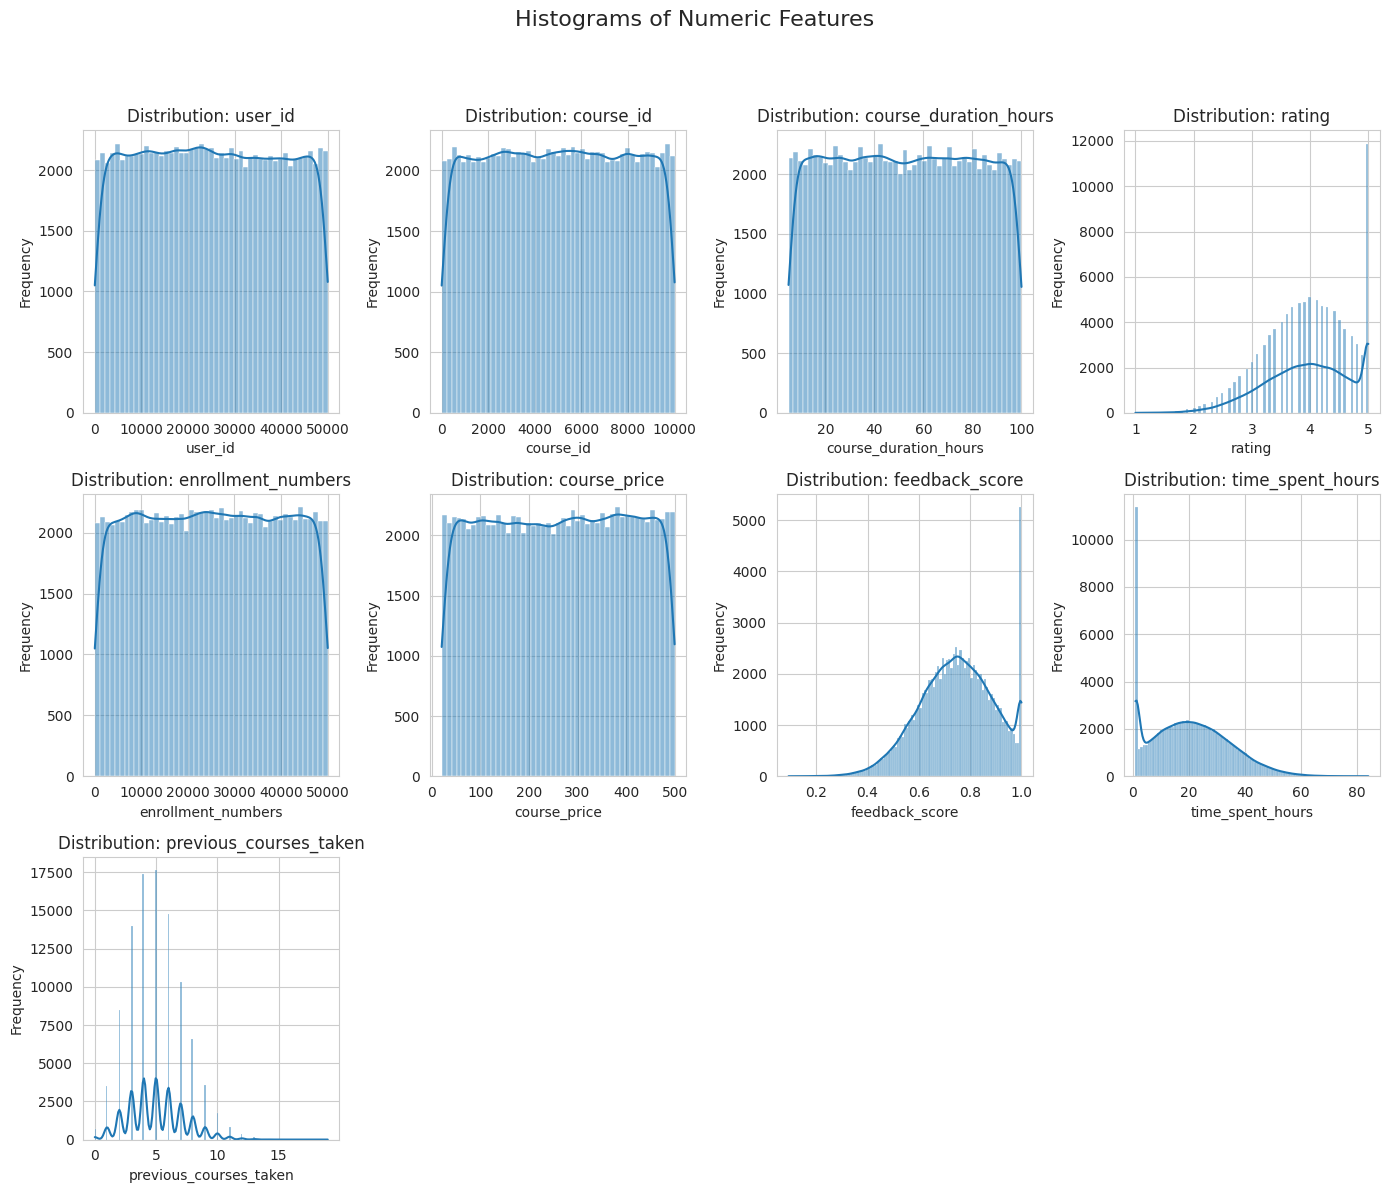

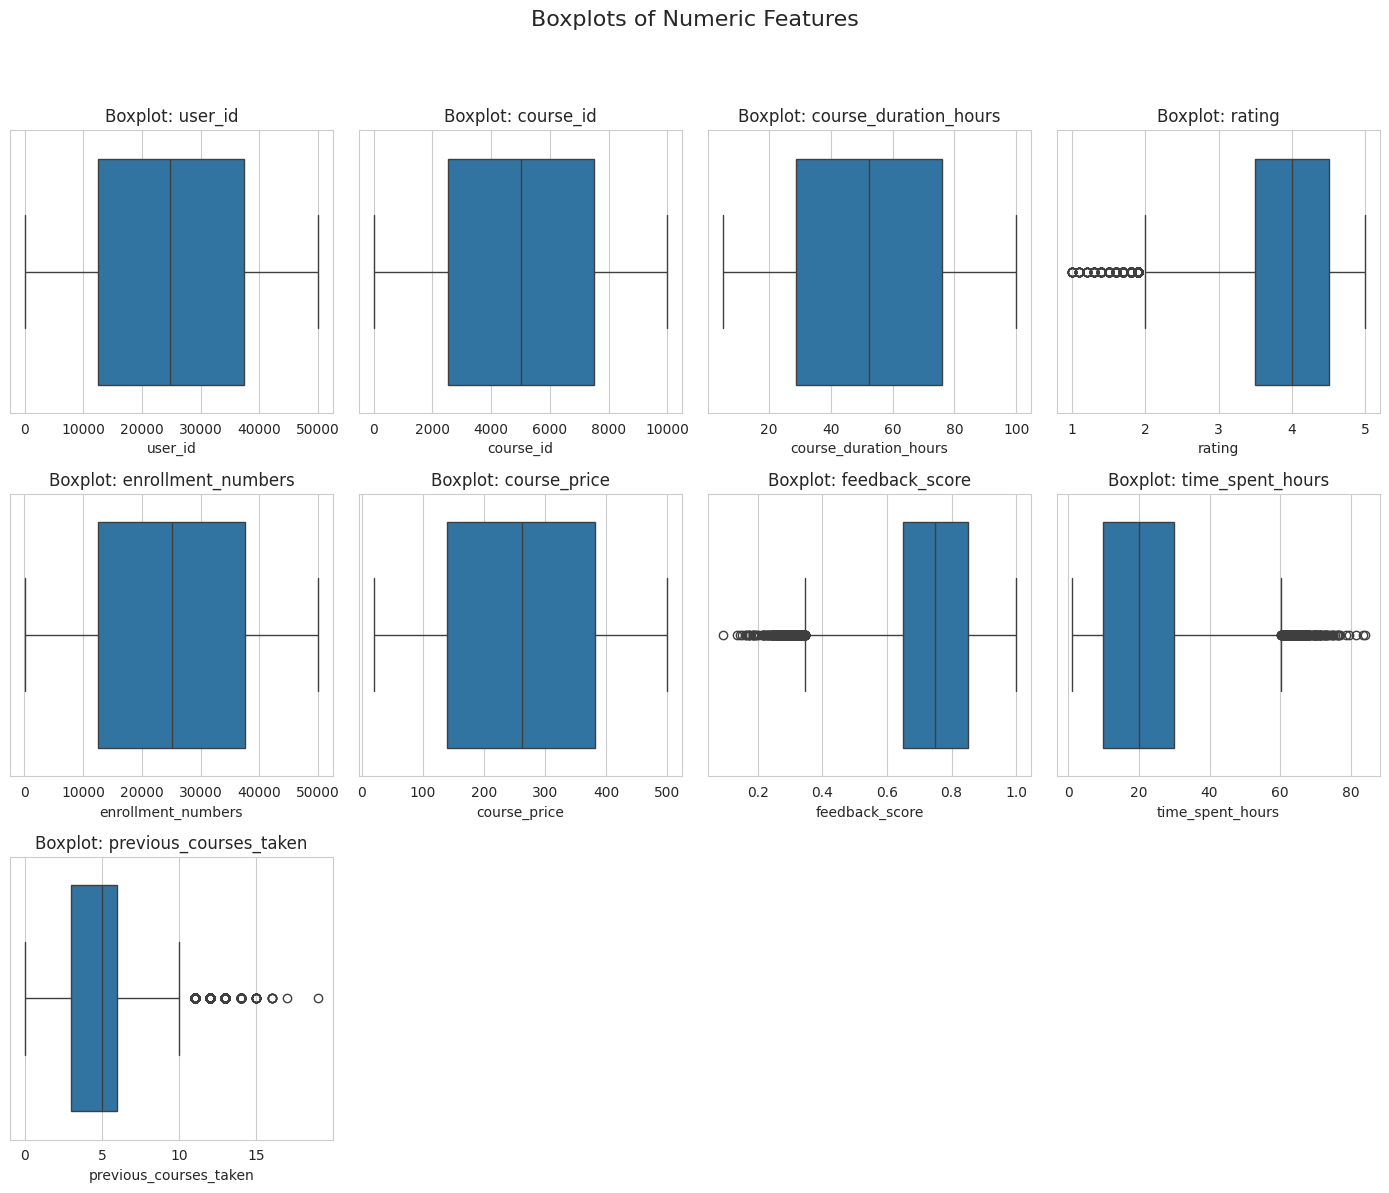

Histograms and boxplots for numeric features generated.


In [8]:
print("\n--- Univariate Analysis: Numeric Features ---")
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns detected:", num_cols)

# Histograms
plt.figure(figsize=(14, 4 * ((len(num_cols) + 3) // 4)))
plt.suptitle('Histograms of Numeric Features', y=1.02, fontsize=16)
for i, col in enumerate(num_cols):
    plt.subplot((len(num_cols) + 3) // 4, 4, i + 1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

# Boxplots to find outliers for numeric cols
plt.figure(figsize=(14, 4 * ((len(num_cols) + 3) // 4)))
plt.suptitle('Boxplots of Numeric Features', y=1.02, fontsize=16)
for i, col in enumerate(num_cols):
    plt.subplot((len(num_cols) + 3) // 4, 4, i + 1)
    sns.boxplot(x=df[col].dropna())
    plt.title(f'Boxplot: {col}')
    plt.xlabel(col)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

print("Histograms and boxplots for numeric features generated.")


--- Univariate Analysis: Categorical Features ---
Categorical columns detected: ['course_name', 'instructor', 'certification_offered', 'difficulty_level', 'study_material_available']


/tmp/ipython-input-1655870904.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.values, y=vc.index, palette='viridis')


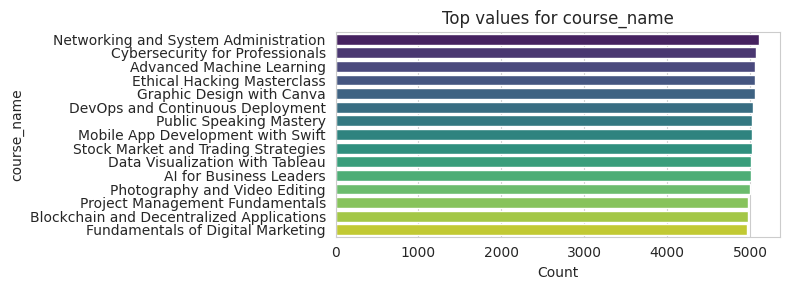

/tmp/ipython-input-1655870904.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.values, y=vc.index, palette='viridis')


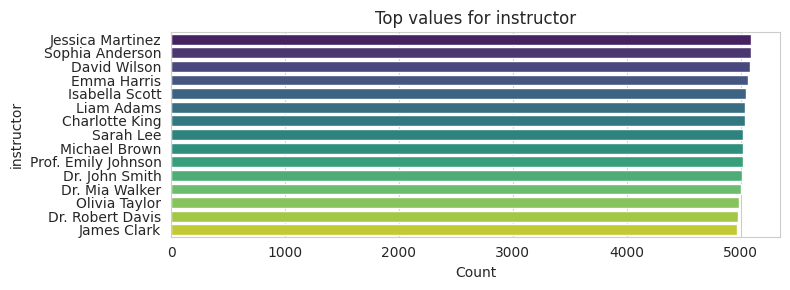

/tmp/ipython-input-1655870904.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.values, y=vc.index, palette='viridis')


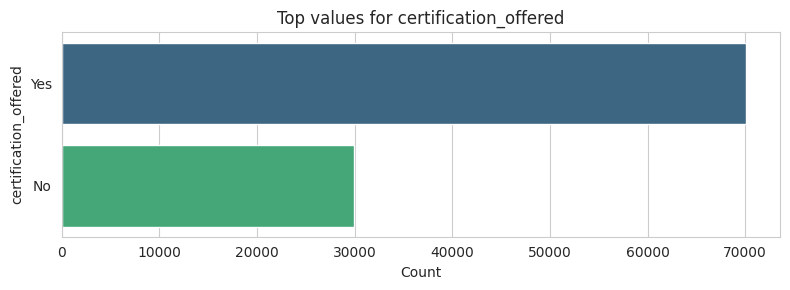

/tmp/ipython-input-1655870904.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.values, y=vc.index, palette='viridis')


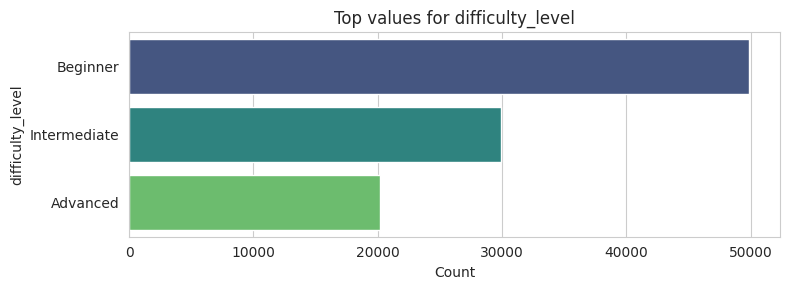

/tmp/ipython-input-1655870904.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.values, y=vc.index, palette='viridis')


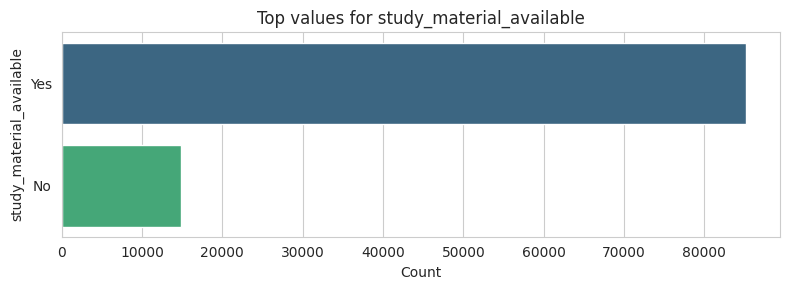

Bar plots for categorical features generated.


In [10]:
print("\n--- Univariate Analysis: Categorical Features ---")
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns detected:", cat_cols)

for col in cat_cols:
    plt.figure(figsize=(8,3))
    vc = df[col].value_counts().nlargest(15)
    sns.barplot(x=vc.values, y=vc.index, palette='viridis')
    plt.title(f'Top values for {col}')
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

print("Bar plots for categorical features generated.")


--- Bivariate Analysis ---


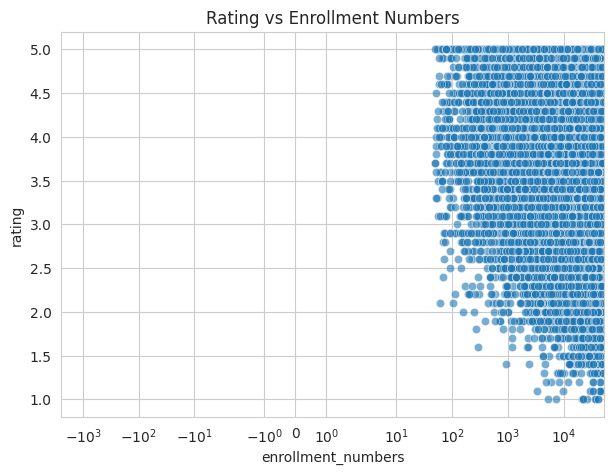

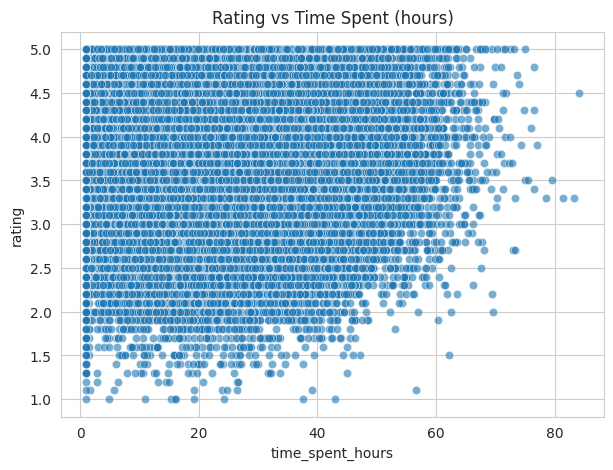

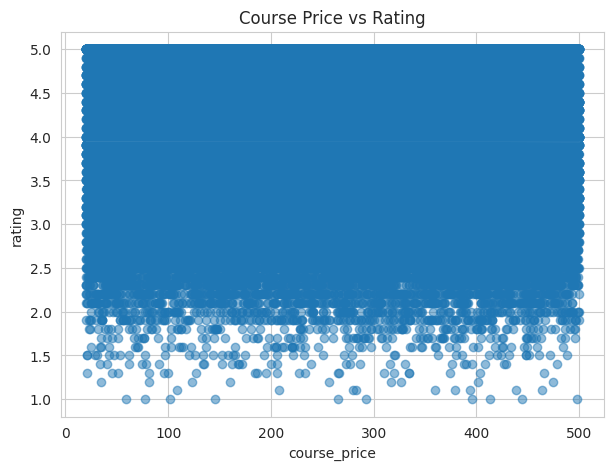

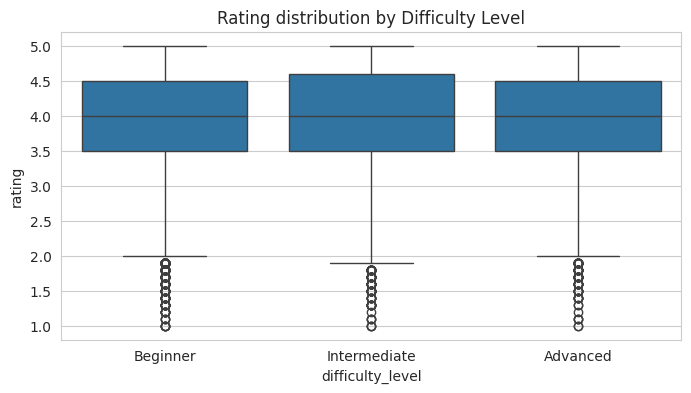

Bivariate analysis plots generated.


In [11]:
print("\n--- Bivariate Analysis ---")

# Rating vs Enrollment_numbers
if ('rating' in df.columns) and ('enrollment_numbers' in df.columns):
    plt.figure(figsize=(7,5))
    sns.scatterplot(data=df, x='enrollment_numbers', y='rating', alpha=0.6)
    plt.xscale('symlog')  # if enrollment has wide range
    plt.title('Rating vs Enrollment Numbers')
    plt.show()

# Rating vs Time Spent
if ('rating' in df.columns) and ('time_spent_hours' in df.columns):
    plt.figure(figsize=(7,5))
    sns.scatterplot(data=df, x='time_spent_hours', y='rating', alpha=0.6)
    plt.title('Rating vs Time Spent (hours)')
    plt.show()

# Price vs Rating
if ('course_price' in df.columns) and ('rating' in df.columns):
    plt.figure(figsize=(7,5))
    sns.regplot(data=df, x='course_price', y='rating', scatter_kws={'alpha':0.5})
    plt.title('Course Price vs Rating')
    plt.show()

# Average rating by difficulty_level (if present)
if 'difficulty_level' in df.columns and 'rating' in df.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df, x='difficulty_level', y='rating')
    plt.title('Rating distribution by Difficulty Level')
    plt.show()

print("Bivariate analysis plots generated.")


--- Correlations (Numeric Features) ---


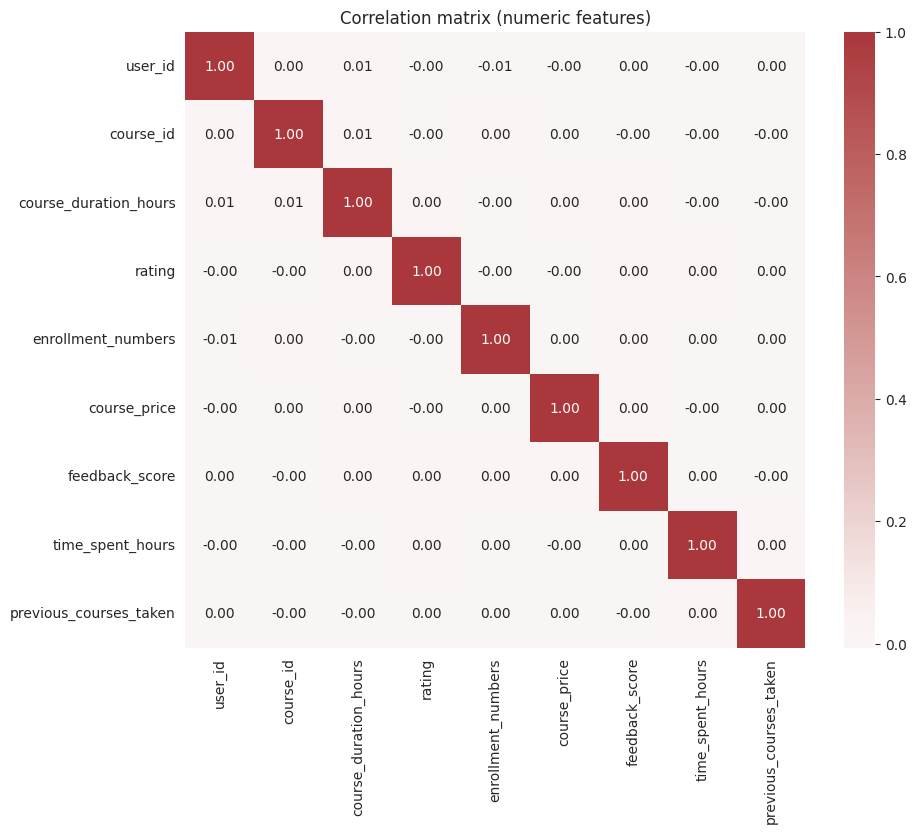

,user_id,course_id,course_duration_hours,rating,enrollment_numbers,course_price,feedback_score,time_spent_hours,previous_courses_taken
user_id,1.000000,0.001386,0.006529,-0.002499,-0.006565,-0.001228,0.000257,-0.004690,0.000682
course_id,0.001386,1.000000,0.005748,-0.000926,0.001915,0.000230,-0.004000,-0.001025,-0.001796
course_duration_hours,0.006529,0.005748,1.000000,0.001650,-0.000591,0.002784,0.001806,-0.001776,-0.002122
rating,-0.002499,-0.000926,0.001650,1.000000,-0.001110,-0.001431,0.001477,0.002027,0.000579
enrollment_numbers,-0.006565,0.001915,-0.000591,-0.001110,1.000000,0.000441,0.001707,0.000402,0.000049
course_price,-0.001228,0.000230,0.002784,-0.001431,0.000441,1.000000,0.004129,-0.002841,0.000842
feedback_score,0.000257,-0.004000,0.001806,0.001477,0.001707,0.004129,1.000000,0.000667,-0.001546
time_spent_hours,-0.004690,-0.001025,-0.001776,0.002027,0.000402,-0.002841,0.000667,1.000000,0.002991
previous_courses_taken,0.000682,-0.001796,-0.002122,0.000579,0.000049,0.000842,-0.001546,0.002991,1.000000



Top positive correlations with rating:


,rating
time_spent_hours,0.002027
course_duration_hours,0.001650
feedback_score,0.001477
previous_courses_taken,0.000579
course_id,-0.000926
enrollment_numbers,-0.001110
course_price,-0.001431
user_id,-0.002499



Top negative correlations with rating:


,rating
time_spent_hours,0.002027
course_duration_hours,0.001650
feedback_score,0.001477
previous_courses_taken,0.000579
course_id,-0.000926
enrollment_numbers,-0.001110
course_price,-0.001431
user_id,-0.002499


Correlation matrix and top correlations with rating generated.


In [12]:
print(
"\n--- Correlations (Numeric Features) ---"
)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if len(num_cols) >= 2:
    corr = df[num_cols].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', center=0)
    plt.title('Correlation matrix (numeric features)')
    plt.show()
    display(corr)

    # Print top positive/negative correlated pairs with rating (if rating exists)
    if 'rating' in df.columns:
        corr_with_rating = corr['rating'].drop('rating').sort_values(ascending=False)
        print("\nTop positive correlations with rating:")
        display(corr_with_rating.head(10))
        print("\nTop negative correlations with rating:")
        display(corr_with_rating.tail(10))

print("Correlation matrix and top correlations with rating generated.")

In [13]:
print("\n--- Business-Focused Aggregations ---")

# Top courses by enrollment
if 'enrollment_numbers' in df.columns:
    top_by_enroll = df.groupby(['course_id','course_name'])['enrollment_numbers'].sum().reset_index()
    top_by_enroll = top_by_enroll.sort_values('enrollment_numbers', ascending=False).head(15)
    print("\nTop courses by total enrollments:")
    display(top_by_enroll)

# Top rated courses (with minimum enrollments threshold)
if {'rating','enrollment_numbers','course_id','course_name'}.issubset(df.columns):
    min_enroll = max(5, int(df['enrollment_numbers'].median()))  # ensure some threshold
    avg_ratings = df.groupby(['course_id','course_name']).agg(
        avg_rating=('rating','mean'),
        enroll_sum=('enrollment_numbers','sum'),
        count_reviews=('rating','count')
    ).reset_index()
    top_rated = avg_ratings[(avg_ratings['enroll_sum'] >= min_enroll)].sort_values('avg_rating', ascending=False).head(15)
    print(f"\nTop rated courses (min total enrollments >= {min_enroll}):")
    display(top_rated)

# Certification offered breakdown
if 'certification_offered' in df.columns:
    print("\nCertification offered counts:")
    display(df['certification_offered'].value_counts())

# Study material available breakdown
if 'study_material_available' in df.columns:
    print("\nStudy material available counts:")
    display(df['study_material_available'].value_counts())

print("Business-focused aggregations generated.")


--- Business-Focused Aggregations ---

Top courses by total enrollments:


,course_id,course_name,enrollment_numbers
65592,8332,Mobile App Development with Swift,192439
58477,7429,Blockchain and Decentralized Applications,186634
59550,7567,Cloud Computing Essentials,180219
39255,4994,Cybersecurity for Professionals,173595
73305,9317,Blockchain and Decentralized Applications,172057
67950,8636,Cloud Computing Essentials,170766
35062,4467,Cybersecurity for Professionals,170102
54550,6927,Python for Beginners,168786
5363,682,Networking and System Administration,168542
50120,6366,Advanced Machine Learning,167099



Top rated courses (min total enrollments >= 25057):


,course_id,course_name,avg_rating,enroll_sum,count_reviews
63,10,Data Visualization with Tableau,5.0,42508,1
67,11,Advanced Machine Learning,5.0,46677,1
64759,8223,Stock Market and Trading Strategies,5.0,47156,1
25597,3261,Project Management Fundamentals,5.0,36381,1
37289,4743,Stock Market and Trading Strategies,5.0,46274,1
131,18,Personal Finance and Wealth Building,5.0,44893,1
78580,9986,Project Management Fundamentals,5.0,26644,1
37073,4716,Public Speaking Mastery,5.0,44437,1
37219,4734,Project Management Fundamentals,5.0,28364,1
37224,4735,Cybersecurity for Professionals,5.0,29930,1



Certification offered counts:


,count
certification_offered,
Yes,70059
No,29941



Study material available counts:


,count
study_material_available,
Yes,85147
No,14853


Business-focused aggregations generated.


In [14]:
print("\n--- Feature Engineering Suggestions ---")
print("\nFeature engineering suggestions:")
print(" - Create a text field combining course_name + instructor + difficulty for content-based features.")
print(" - Create engagement_score using time_spent_hours * feedback_score or normalized rating.")
print(" - Flag 'popular' courses where enrollment_numbers > median(enrollment_numbers).")
print(" - Bucketize course_price into price tiers (low / medium / high).")
print("Feature engineering suggestions printed.")


--- Feature Engineering Suggestions ---

Feature engineering suggestions:
 - Create a text field combining course_name + instructor + difficulty for content-based features.
 - Create engagement_score using time_spent_hours * feedback_score or normalized rating.
 - Flag 'popular' courses where enrollment_numbers > median(enrollment_numbers).
 - Bucketize course_price into price tiers (low / medium / high).
Feature engineering suggestions printed.


In [15]:
import os

print("\n--- Saving EDA Summary ---")

# Create the directory if it doesn't exist
output_dir = '/mnt/data'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: {output_dir}")

summary_df = pd.DataFrame({
    'column': df.columns,
    'dtype': df.dtypes.astype(str),
    'n_unique': [df[c].nunique() for c in df.columns],
    'n_missing': [df[c].isnull().sum() for c in df.columns]
})
summary_df.to_csv(os.path.join(output_dir, 'eda_summary_online_courses.csv'), index=False)
print("EDA summary saved to /mnt/data/eda_summary_online_courses.csv")

print("\nEDA complete. Explore above outputs and plots; if you want,")
print("I can now clean data, create features, or build recommendation models (content/collab/hybrid).")


--- Saving EDA Summary ---
Created directory: /mnt/data
EDA summary saved to /mnt/data/eda_summary_online_courses.csv

EDA complete. Explore above outputs and plots; if you want,
I can now clean data, create features, or build recommendation models (content/collab/hybrid).


In [16]:
# We'll focus on these columns for recommendation:
# user_id, course_id, rating, enrollment_numbers, course_price, course_duration_hours, etc.

necessary_cols = ["user_id", "course_id", "rating", "course_name",
                  "enrollment_numbers", "course_price", "course_duration_hours"]

for col in necessary_cols:
    if col not in df.columns:
        print(f"WARNING: {col} not found in dataset!")

# Drop rows with missing user_id / course_id / rating
df = df.dropna(subset=["user_id", "course_id", "rating"])

# Keep only relevant columns (others are still available if needed)
df = df[necessary_cols]

# Ensure types
df["user_id"] = df["user_id"].astype(int)
df["course_id"] = df["course_id"].astype(int)
df["rating"] = df["rating"].astype(float)

# Fill missing numeric with 0 (for business features like enrollment, price)
for col in ["enrollment_numbers", "course_price", "course_duration_hours"]:
    if col in df.columns:
        df[col] = df[col].fillna(0)

print("\nAfter cleaning:")
print(df.head())


After cleaning:
   user_id  course_id  rating                       course_name  \
0    15796       9366     5.0              Python for Beginners   
1      861       1928     4.3   Cybersecurity for Professionals   
2    38159       9541     3.9  DevOps and Continuous Deployment   
3    44733       3708     3.1   Project Management Fundamentals   
4    11285       3361     2.8       Ethical Hacking Masterclass   

   enrollment_numbers  course_price  course_duration_hours  
0               21600        317.50                   39.1  
1               15379         40.99                   36.3  
2                6431        380.81                   13.4  
3               48245        342.80                   58.3  
4               34556        381.01                   30.8  


In [17]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print("\nTrain interactions:", train_df.shape)
print("Test interactions:", test_df.shape)


Train interactions: (80000, 7)
Test interactions: (20000, 7)


In [18]:
# Ensure df is loaded and cleaned, then split before pivoting

# Load data (re-run in case previous cell was not executed)
df = pd.read_excel("online_course_recommendation_v2.xlsx")

# Basic Cleaning (re-run necessary steps)
necessary_cols = ["user_id", "course_id", "rating", "course_name",
                  "enrollment_numbers", "course_price", "course_duration_hours"]

# Drop rows with missing user_id / course_id / rating
df = df.dropna(subset=["user_id", "course_id", "rating"])

# Keep only relevant columns
df = df[necessary_cols]

# Ensure types
df["user_id"] = df["user_id"].astype(int)
df["course_id"] = df["course_id"].astype(int)
df["rating"] = df["rating"].astype(float)

# Fill missing numeric with 0
for col in ["enrollment_numbers", "course_price", "course_duration_hours"]:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# TRAIN/TEST SPLIT (FOR EVALUATION OF RECOMMENDER)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Pivot: rows = users, columns = courses, values = rating
user_course_matrix = train_df.pivot_table(
    index="user_id",
    columns="course_id",
    values="rating"
).fillna(0.0)

print("\nUser-Course Matrix shape:", user_course_matrix.shape)


User-Course Matrix shape: (40003, 9997)


In [19]:
# We compute cosine similarity between course vectors (columns)
# transpose to shape: courses x users
course_user_matrix = user_course_matrix.T  # rows = course_id, columns = user_id

# Compute cosine similarity
course_similarity = cosine_similarity(course_user_matrix)
course_similarity_df = pd.DataFrame(
    course_similarity,
    index=course_user_matrix.index,
    columns=course_user_matrix.index
)

print("\nCourse-Course similarity matrix shape:", course_similarity_df.shape)


Course-Course similarity matrix shape: (9997, 9997)


In [20]:
# Popularity: number of enrollments / number of ratings
course_stats = train_df.groupby("course_id").agg(
    avg_rating=("rating", "mean"),
    num_ratings=("rating", "count"),
    avg_price=("course_price", "mean"),
    avg_duration=("course_duration_hours", "mean"),
    avg_enrollment=("enrollment_numbers", "mean")
).reset_index()

print("\nCourse business stats:")
print(course_stats.head())

# Merge course name (if available)
course_names = df[["course_id", "course_name"]].drop_duplicates()
course_stats = course_stats.merge(course_names, on="course_id", how="left")


Course business stats:
   course_id  avg_rating  num_ratings   avg_price  avg_duration  \
0          1    3.855556            9  205.188889     52.933333   
1          2    4.125000            8  285.628750     57.900000   
2          3    3.950000            2  358.815000     48.800000   
3          4    3.857143            7  322.171429     51.157143   
4          5    3.866667            6  233.215000     61.000000   

   avg_enrollment  
0    23704.111111  
1    29101.875000  
2    48984.000000  
3    21731.142857  
4    23480.833333  


In [21]:
def get_similar_courses(course_id, top_n=10, min_similarity=0.0):
    """
    Returns top N courses similar to given course_id based on CF similarity.
    Includes avg_rating and num_ratings for business use.
    """
    if course_id not in course_similarity_df.index:
        print(f"Course {course_id} not found in similarity matrix.")
        return pd.DataFrame()

    # All similarity scores for this course
    sims = course_similarity_df.loc[course_id].drop(course_id)  # drop self

    # Filter by minimum similarity
    sims = sims[sims >= min_similarity]

    # Sort descending
    sims = sims.sort_values(ascending=False).head(top_n)

    sim_df = sims.reset_index()
    sim_df.columns = ["course_id", "similarity"]

    # Attach course stats (avg_rating, num_ratings, name)
    sim_df = sim_df.merge(course_stats, on="course_id", how="left")

    return sim_df


# Example:
print("\nExample similar courses:")
example_course_id = course_stats["course_id"].iloc[0]
print("Example course_id:", example_course_id)
print(get_similar_courses(example_course_id, top_n=5))


Example similar courses:
Example course_id: 1
    course_id  similarity  avg_rating  num_ratings   avg_price  avg_duration  \
0        9720    0.177031    3.960000            5  286.990000     64.260000   
1        9720    0.177031    3.960000            5  286.990000     64.260000   
2        9720    0.177031    3.960000            5  286.990000     64.260000   
3        9720    0.177031    3.960000            5  286.990000     64.260000   
4        9720    0.177031    3.960000            5  286.990000     64.260000   
5        8004    0.157632    3.877778            9  266.477778     61.944444   
6        8004    0.157632    3.877778            9  266.477778     61.944444   
7        8004    0.157632    3.877778            9  266.477778     61.944444   
8        8004    0.157632    3.877778            9  266.477778     61.944444   
9        8004    0.157632    3.877778            9  266.477778     61.944444   
10       8004    0.157632    3.877778            9  266.477778     61.944

In [22]:
def recommend_for_user(user_id, top_n=10,
                       alpha_sim=0.6, alpha_pop=0.2, alpha_rating=0.2):
    """
    Recommend courses to a user using:
      - CF similarity (item-based)
      - Popularity (num_ratings or enrollments)
      - Avg rating

    Business objective:
      score = alpha_sim * similarity
             + alpha_pop * normalized_popularity
             + alpha_rating * normalized_avg_rating

    - alpha_* coefficients decide the business focus:
        sim high  -> very personalized
        pop high  -> push popular/high-traffic courses
        rating high -> push high quality courses
    """
    # If user has no interactions in train, fallback to popular courses
    if user_id not in user_course_matrix.index:
        print(f"User {user_id} not found in training data. Returning popular courses.")
        # Fallback: business ranking only
        popular = course_stats.copy()
        # Use num_ratings as popularity if avg_enrollment is missing
        popular["popularity"] = popular["avg_enrollment"].fillna(0) + \
                                popular["num_ratings"].fillna(0)
        # Normalize features
        popular["popularity_norm"] = (popular["popularity"] - popular["popularity"].min()) / \
                                     (popular["popularity"].max() - popular["popularity"].min() + 1e-9)
        popular["avg_rating_norm"] = (popular["avg_rating"] - popular["avg_rating"].min()) / \
                                     (popular["avg_rating"].max() - popular["avg_rating"].min() + 1e-9)
        # No similarity info here, so alpha_sim not used
        popular["business_score"] = alpha_pop * popular["popularity_norm"] + \
                                    alpha_rating * popular["avg_rating_norm"]
        popular = popular.sort_values("business_score", ascending=False).head(top_n)
        return popular[["course_id", "course_name", "avg_rating", "num_ratings", "business_score"]]

    # Courses user already interacted with
    user_ratings = user_course_matrix.loc[user_id]
    watched_courses = user_ratings[user_ratings > 0].index.tolist()

    if len(watched_courses) == 0:
        print(f"User {user_id} has no rated courses. Returning popular courses.")
        return recommend_for_user(user_id=-1, top_n=top_n)  # trigger cold-start branch

    # Weighted sum of similarities: courses similar to those user liked
    sim_scores = pd.Series(dtype=float)

    for course in watched_courses:
        rating = user_ratings[course]
        # Get similarity scores for 'course'
        sims = course_similarity_df.loc[course]

        # Weight by user's rating (more weight for highly rated courses)
        sims = sims * rating

        # Accumulate
        sim_scores = sim_scores.add(sims, fill_value=0.0)

    # Remove courses already watched
    sim_scores = sim_scores.drop(labels=watched_courses, errors="ignore")

    # Turn into DataFrame
    rec_df = sim_scores.reset_index()
    rec_df.columns = ["course_id", "sim_score"]

    # Attach business stats
    rec_df = rec_df.merge(course_stats, on="course_id", how="left")

    # Fill missing stats
    rec_df["num_ratings"] = rec_df["num_ratings"].fillna(0)
    rec_df["avg_rating"] = rec_df["avg_rating"].fillna(rec_df["avg_rating"].mean())

    # Popularity proxy: enrollments + num_ratings
    rec_df["popularity"] = rec_df["avg_enrollment"].fillna(0) + rec_df["num_ratings"]

    # Normalize features for business scoring
    # (avoid division by zero with small epsilon)
    def normalize(col):
        return (col - col.min()) / (col.max() - col.min() + 1e-9)

    rec_df["sim_norm"] = normalize(rec_df["sim_score"])
    rec_df["pop_norm"] = normalize(rec_df["popularity"])
    rec_df["rating_norm"] = normalize(rec_df["avg_rating"])

    # Business score: combine personalization + popularity + rating
    rec_df["business_score"] = (
        alpha_sim * rec_df["sim_norm"] +
        alpha_pop * rec_df["pop_norm"] +
        alpha_rating * rec_df["rating_norm"]
    )

    # Sort by business_score
    rec_df = rec_df.sort_values("business_score", ascending=False).head(top_n)

    return rec_df[[
        "course_id",
        "course_name",
        "business_score",
        "sim_score",
        "avg_rating",
        "num_ratings",
        "avg_enrollment",
        "avg_price",
        "avg_duration"
    ]]


# Example: recommend for some user
example_user_id = user_course_matrix.index[0]
print("\nExample recommendations for user:", example_user_id)
print(recommend_for_user(example_user_id, top_n=5))


Example recommendations for user: 1
       course_id                           course_name  business_score  \
78321       9955       Cybersecurity for Professionals        0.768074   
78322       9955        Fitness and Nutrition Coaching        0.768074   
78323       9955   Stock Market and Trading Strategies        0.768074   
78320       9955     Mobile App Development with Swift        0.768074   
78319       9955  Networking and System Administration        0.768074   

       sim_score  avg_rating  num_ratings  avg_enrollment  avg_price  \
78321   0.783244         3.9            5         17821.2     99.194   
78322   0.783244         3.9            5         17821.2     99.194   
78323   0.783244         3.9            5         17821.2     99.194   
78320   0.783244         3.9            5         17821.2     99.194   
78319   0.783244         3.9            5         17821.2     99.194   

       avg_duration  
78321         37.68  
78322         37.68  
78323         37.68

## 9. SIMPLE EVALUATION: HIT-RATE @ K

In [23]:
def hit_rate_at_k(k=10):
    """
    Simple offline metric:
      For each user in test, check if at least one of the test courses
      appears in top-k recommendations from train-based model.
      Metric ~ "what fraction of users got at least one relevant course in top-k?"
    """
    # Users that exist in train user_course_matrix
    users_in_train = set(user_course_matrix.index)

    # group test interactions by user
    user_test_courses = test_df.groupby("user_id")["course_id"].apply(set)

    hits = 0
    total = 0

    for user_id, test_courses in user_test_courses.items():
        if user_id not in users_in_train:
            continue  # skip cold-start users for this metric
        total += 1

        recs = recommend_for_user(user_id, top_n=k)
        recommended_courses = set(recs["course_id"].tolist())

        # hit if any of the test courses is in recommended list
        if len(recommended_courses.intersection(test_courses)) > 0:
            hits += 1

    if total == 0:
        print("No overlapping users between train & test for evaluation.")
        return None

    return hits / total

hr10 = hit_rate_at_k(k=10)
print("\nHit-Rate @ 10:", hr10)


Hit-Rate @ 10: 0.0005308258133009783


In [24]:
import joblib

joblib.dump(user_course_matrix, "user_course_matrix.joblib")
joblib.dump(course_similarity_df, "course_similarity_df.joblib")
joblib.dump(course_stats, "course_stats.joblib")

print("\nSaved:")
print("- user_course_matrix.joblib")
print("- course_similarity_df.joblib")
print("- course_stats.joblib")


Saved:
- user_course_matrix.joblib
- course_similarity_df.joblib
- course_stats.joblib


In [25]:
pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 74.0 MB/s eta 0:00:00


In [26]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import joblib # Import joblib

st.set_page_config(page_title="Course Recommendation System", layout="wide")
st.title("🎓Course Recommendation System")

@st.cache_resource # Use st.cache_resource for heavy objects like dataframes and models
def load_all_data_and_models():
    # Load original dataframe for course names and selection boxes
    df = pd.read_excel("online_course_recommendation_v2.xlsx")

    # Basic Cleaning for df (similar to what was done in the notebook for course_names)
    necessary_cols = ["user_id", "course_id", "rating", "course_name",
                      "enrollment_numbers", "course_price", "course_duration_hours"]
    df = df.dropna(subset=["user_id", "course_id", "rating"])
    df = df[necessary_cols]

    df["user_id"] = df["user_id"].astype(int)
    df["course_id"] = df["course_id"].astype(int)
    df["rating"] = df["rating"].astype(float)

    for col in ["enrollment_numbers", "course_price", "course_duration_hours"]:
        df[col] = df[col].fillna(0)


    # Load pre-computed matrices and stats
    user_course_matrix = joblib.load("user_course_matrix.joblib")
    course_similarity_df = joblib.load("course_similarity_df.joblib")
    course_stats = joblib.load("course_stats.joblib")

    return df, user_course_matrix, course_similarity_df, course_stats

df, user_course_matrix, course_similarity_df, course_stats = load_all_data_and_models()

# Define normalization function (used in the more advanced recommend_for_user)
def normalize(series):
    min_val = series.min()
    max_val = series.max()
    if max_val - min_val == 0: # Avoid division by zero
        return pd.Series(0.0, index=series.index)
    return (series - min_val) / (max_val - min_val)

def get_similar_courses(course_id, top_n=10, min_similarity=0.0):
    """
    Returns top N courses similar to given course_id based on CF similarity.
    Includes avg_rating and num_ratings for business use.
    """
    if course_id not in course_similarity_df.index:
        return pd.DataFrame({"Message": [f"Course {course_id} not found in similarity matrix."]})

    # All similarity scores for this course
    sims = course_similarity_df.loc[course_id].drop(course_id)  # drop self

    # Filter by minimum similarity
    sims = sims[sims >= min_similarity]

    # Sort descending
    sims = sims.sort_values(ascending=False).head(top_n)

    if sims.empty:
        return pd.DataFrame({"Message": [f"No similar courses found for course {course_id} with similarity >= {min_similarity}."]})

    sim_df = sims.reset_index()
    sim_df.columns = ["course_id", "similarity"]

    # Attach course stats (avg_rating, num_ratings, name)
    sim_df = sim_df.merge(course_stats.drop_duplicates(subset=['course_id']), on="course_id", how="left")

    return sim_df.round(2)


def recommend_for_user(user_id, top_n=10, alpha_sim=0.6, alpha_pop=0.2, alpha_rating=0.2):
    """
    Recommend courses to a user using:
      - CF similarity (item-based)
      - Popularity (num_ratings or enrollments)
      - Avg rating

    Business objective:
      score = alpha_sim * similarity
             + alpha_pop * normalized_popularity
             + alpha_rating * normalized_avg_rating

    - alpha_* coefficients decide the business focus:
        sim high  -> very personalized
        pop high  -> push popular/high-traffic courses
        rating high -> push high quality courses
    """
    # If user has no interactions in train, fallback to popular courses
    if user_id not in user_course_matrix.index:
        st.info(f"User {user_id} not found in training data. Returning popular courses.")
        # Fallback: business ranking only
        popular = course_stats.copy()
        # Use num_ratings as popularity if avg_enrollment is missing
        popular["popularity"] = popular["avg_enrollment"].fillna(0) + \
                                popular["num_ratings"].fillna(0)
        # Normalize features
        popular["popularity_norm"] = normalize(popular["popularity"])
        popular["avg_rating_norm"] = normalize(popular["avg_rating"])

        popular["business_score"] = (alpha_pop * popular["popularity_norm"] +
                                     alpha_rating * popular["avg_rating_norm"])
        popular = popular.sort_values("business_score", ascending=False).head(top_n)
        return popular[["course_id", "course_name", "avg_rating", "num_ratings", "business_score"]].round(2)

    # Courses user already interacted with
    user_ratings = user_course_matrix.loc[user_id]
    watched_courses = user_ratings[user_ratings > 0].index.tolist()

    if len(watched_courses) == 0:
        st.info(f"User {user_id} has no rated courses. Returning popular courses.")
        # Trigger cold-start branch with a dummy user_id that won't be in the matrix
        return recommend_for_user(user_id=-1, top_n=top_n, alpha_sim=0, alpha_pop=alpha_pop, alpha_rating=alpha_rating)

    # Weighted sum of similarities: courses similar to those user liked
    sim_scores = pd.Series(dtype=float)

    for course in watched_courses:
        rating = user_ratings[course]
        # Get similarity scores for 'course'
        sims = course_similarity_df.loc[course]

        # Weight by user's rating (more weight for highly rated courses)
        sims = sims * rating

        # Accumulate
        sim_scores = sim_scores.add(sims, fill_value=0.0)

    # Remove courses already watched
    sim_scores = sim_scores.drop(labels=watched_courses, errors="ignore")

    # Turn into DataFrame
    rec_df = sim_scores.reset_index()
    rec_df.columns = ["course_id", "sim_score"]

    # Attach business stats
    rec_df = rec_df.merge(course_stats.drop_duplicates(subset=['course_id']), on="course_id", how="left")

    # Fill missing stats for normalization (can happen for very new courses)
    rec_df["num_ratings"] = rec_df["num_ratings"].fillna(0)
    rec_df["avg_rating"] = rec_df["avg_rating"].fillna(rec_df["avg_rating"].mean() if not rec_df["avg_rating"].empty else 0)
    rec_df["avg_enrollment"] = rec_df["avg_enrollment"].fillna(0)

    # Popularity proxy: enrollments + num_ratings
    rec_df["popularity"] = rec_df["avg_enrollment"] + rec_df["num_ratings"]

    # Normalize features for business scoring
    rec_df["sim_norm"] = normalize(rec_df["sim_score"])
    rec_df["pop_norm"] = normalize(rec_df["popularity"])
    rec_df["rating_norm"] = normalize(rec_df["avg_rating"])

    # Business score: combine personalization + popularity + rating
    rec_df["business_score"] = (
        alpha_sim * rec_df["sim_norm"] +
        alpha_pop * rec_df["pop_norm"] +
        alpha_rating * rec_df["rating_norm"]
    )

    # Sort by business_score
    rec_df = rec_df.sort_values("business_score", ascending=False).head(top_n)

    return rec_df[[
        "course_id",
        "course_name",
        "business_score",
        "sim_score",
        "avg_rating",
        "num_ratings",
        "avg_enrollment",
        "avg_price",
        "avg_duration"
    ]].round(2)


# UI Sidebar
st.sidebar.header("Choose Recommendation Type")
option = st.sidebar.radio(
    "Select an option",
    ["Recommend Similar Courses", "Recommend for User"]
)

if option == "Recommend Similar Courses":
    st.subheader("🔍 Similar Course Finder")
    course_id = st.selectbox("Select Course ID",
                             sorted(df["course_id"].unique()))
    top_n_sim = st.slider("Number of similar courses to recommend", 1, 20, 10)
    min_sim_thresh = st.slider("Minimum similarity threshold", 0.0, 1.0, 0.1, 0.05)

    if st.button("Find Similar Courses"):
        with st.spinner('Finding similar courses...'):
            result = get_similar_courses(course_id, top_n=top_n_sim, min_similarity=min_sim_thresh)
            if not result.empty and "Message" not in result.columns:
                st.dataframe(result)
            else:
                st.write(result["Message"].iloc[0])


elif option == "Recommend for User":
    st.subheader("🙋 Personalized Recommendation")
    user_id = st.selectbox("Select User ID",
                           sorted(df["user_id"].unique()))

    st.sidebar.subheader("Recommendation Weights")
    alpha_sim = st.sidebar.slider("Similarity Weight (Personalization)", 0.0, 1.0, 0.6, 0.05)
    alpha_pop = st.sidebar.slider("Popularity Weight", 0.0, 1.0, 0.2, 0.05)
    alpha_rating = st.sidebar.slider("Avg Rating Weight (Quality)", 0.0, 1.0, 0.2, 0.05)
    top_n_user = st.slider("Number of courses to recommend", 1, 20, 10)

    # Ensure weights sum to 1 (or close to it due to float precision)
    total_alpha = alpha_sim + alpha_pop + alpha_rating
    if not (0.99 <= total_alpha <= 1.01):
        st.sidebar.warning(f"Warning: Weights sum to {total_alpha:.2f}. Consider normalizing them to 1 for consistent scoring.")

    if st.button("Recommend Courses"):
        with st.spinner('Generating personalized recommendations...'):
            result = recommend_for_user(user_id,
                                        top_n=top_n_user,
                                        alpha_sim=alpha_sim,
                                        alpha_pop=alpha_pop,
                                        alpha_rating=alpha_rating)
            if not result.empty:
                st.dataframe(result)
            else:
                st.write("No recommendations could be generated for this user.")


st.markdown("---")
st.success("App Running Successfully 🚀 Upload more data to improve recommendations!")

Writing app.py


In [27]:
import os

# List all files and directories in the current working directory
print("Files in current directory:")
for item in os.listdir('.'):
    if os.path.isfile(item):
        print(item)


Files in current directory:
course_stats.joblib
user_course_matrix.joblib
Course_Recomendation_System (1).ipynb
app.py
online_course_recommendation_v2.xlsx
course_similarity_df.joblib


After reviewing the list, replace `'your_actual_filename.ext'` in the code below with the name of the file you wish to download.

In [28]:
from google.colab import files

# IMPORTANT: Replace 'app.py' with the file name from the list above if you want to download a different one
files.download('app.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
from google.colab import files
uploaded = files.upload()


Saving app (4).py to app (4).py


In [30]:
!pip install streamlit scikit-learn openpyxl pyngrok


In [31]:
from pyngrok import ngrok

ngrok.set_auth_token("YOUR_AUTHTOKEN")

print("ngrok authtoken set. Please proceed to the next cell to launch your Streamlit app.")

ngrok authtoken set. Please proceed to the next cell to launch your Streamlit app.


In [32]:
from pyngrok import ngrok

# 🔐 Put YOUR REAL TOKEN here (without quotes like YOUR_AUTHTOKEN)
ngrok.set_auth_token("YOUR_REAL_NGROK_TOKEN_HERE")


In [33]:
from pyngrok import ngrok
ngrok.set_auth_token("36T96FqBKzl0OZbTXimWTBwTZf9_2y13DaHGVHaScARh9QDpD")


In [34]:
# Kill old tunnels if any
ngrok.kill()

# Start Streamlit app
get_ipython().system_raw(
    'streamlit run app.py --server.port 8501 --server.address 0.0.0.0 &'
)

# Create public URL
public_url = ngrok.connect(8501)
public_url


<NgrokTunnel: "https://arya-saltant-tensibly.ngrok-free.dev" -> "http://localhost:8501">